Installing dependencies

In [8]:
# Install PyTorch (Jetson usually has this pre-installed, but for laptop:)
!pip install torch torchvision 

# Install Flower, MedMNIST, and Dashboard tools
!pip install flwr "flwr-datasets[vision]" medmnist streamlit pandas matplotlib seaborn

Medmnist dataset

100%|██████████| 4.17M/4.17M [01:54<00:00, 36.5kB/s]


Dataset Size: 4708
Classes: {'0': 'normal', '1': 'pneumonia'}
Saved sample image to medmnist_sample.png


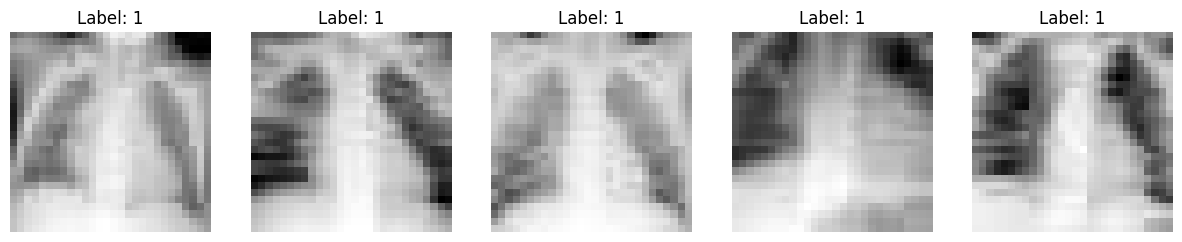

In [3]:
import medmnist
from medmnist import INFO
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torch

# Configuration
DATA_FLAG = 'pneumoniamnist'
info = INFO[DATA_FLAG]
DataClass = getattr(medmnist, info['python_class'])

# Load Data
print(f"Downloading {DATA_FLAG}...")
dataset = DataClass(split='train', download=True, transform=transforms.ToTensor())

# Visual Inspection
print(f"Dataset Size: {len(dataset)}")
print(f"Classes: {info['label']}")

# Display first 5 images
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i in range(5):
    img, label = dataset[i]
    # MedMNIST images are 1x28x28 (Grayscale)
    axes[i].imshow(img.squeeze(), cmap='gray')
    axes[i].set_title(f"Label: {label.item()}")
    axes[i].axis('off')

plt.savefig("medmnist_sample.png")
print("Saved sample image to medmnist_sample.png")

Centralized Training

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import medmnist
from medmnist import INFO

# 1. Setup
DEVICE = "cpu" # torch.device("cuda" if torch.cuda.is_available() else "cpu")
DATA_FLAG = 'pneumoniamnist'
info = INFO[DATA_FLAG]
BATCH_SIZE = 16

# 2. Define Model (Simple CNN for 28x28 images)
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3) # 1 input channel (grayscale)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 3)
        self.fc1 = nn.Linear(32 * 5 * 5, 64)
        self.fc2 = nn.Linear(64, 1) # Binary classification (Pneumonia vs Normal)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 32 * 5 * 5)
        x = torch.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x)) # Sigmoid for binary
        return x

# 3. Train
def main():
    # Load Data
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=[.5], std=[.5])])
    DataClass = getattr(medmnist, info['python_class'])
    train_dataset = DataClass(split='train', transform=transform, download=True)
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

    model = Net().to(DEVICE)
    criterion = nn.BCELoss() # Binary Cross Entropy
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

    print("Starting Centralized Training...")
    for epoch in range(3):
        total_loss = 0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(DEVICE), targets.float().to(DEVICE)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}: Loss {total_loss/len(train_loader):.4f}")

    print("Done.")

if __name__ == "__main__":
    main()

Starting Centralized Training...
Epoch 1: Loss 0.3585
Epoch 2: Loss 0.1647
Epoch 3: Loss 0.1369
Done.


Flower Concepts & Utilities

Flower Architecture:
1. Client: Runs on the Edge. Holds the private data. It receives weights, trains locally, and sends updates back.

2. Server: Runs on the Laptop/server. It aggregates updates (averaging them) and sends new global weights to clients.

3. Strategy: The algorithm used by the server (e.g., FedAvg).

Utils File

The core library that is used by both server and clients for training, evaluation and data partitioning.

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.transforms import Compose, ToTensor, Normalize

DEVICE = "cpu" #torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- 1. MODEL DEFINITION (Unchanged) ---
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 3)
        self.fc1 = nn.Linear(32 * 5 * 5, 64)
        self.fc2 = nn.Linear(64, 1)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 32 * 5 * 5)
        x = torch.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x

# --- 2. TRAINING FUNCTIONS (Unchanged) ---
def train(model, train_loader, epochs=1):
    criterion = nn.BCELoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    model.train()
    for batch in train_loader:
        # Note: formatting matches HF dataset output structure
        images = batch["image"].to(DEVICE)
        labels = batch["label"].float().to(DEVICE)
        
        optimizer.zero_grad()
        loss = criterion(model(images), labels)
        loss.backward()
        optimizer.step()

def test(model, test_loader):
    criterion = nn.BCELoss()
    model.eval()
    loss, correct = 0.0, 0
    with torch.no_grad():
        for batch in test_loader:
            images = batch["image"].to(DEVICE)
            labels = batch["label"].float().to(DEVICE)
            
            outputs = model(images)
            loss += criterion(outputs, labels).item()
            predicted = (outputs > 0.5).float()
            correct += (predicted == labels).sum().item()
    return loss / len(test_loader.dataset), correct / len(test_loader.dataset)

# --- 3. TRANSFORMS (New) ---
# This converts the raw HF Data (PIL Images) to Tensors
def apply_transforms(batch):
    transforms = Compose([ToTensor(), Normalize(mean=[.5], std=[.5])])
    
    # Apply to image column
    batch["image"] = [transforms(img) for img in batch["image"]]
    
    # MedMNIST labels come as lists like [1], we need simple integers/floats
    # We flatten the label list if necessary
    # Note: MedMNIST v2 on HF typically returns labels as integers inside a list
    return batch

Server File

The server file handles the aggregation of the client's local updates and evalutates the computed global model.

In [ ]:
import flwr as fl
import csv
import os
#from fl_utils import Net, test, load_partition # Used for server-side evaluation if needed

# Setup Logging File
CSV_FILE = "fl_metrics.csv"
if os.path.exists(CSV_FILE):
    os.remove(CSV_FILE)
with open(CSV_FILE, "w") as f:
    f.write("round,accuracy,loss\n")

def write_metrics(rnd, accuracy, loss):
    with open(CSV_FILE, "a") as f:
        f.write(f"{rnd},{accuracy},{loss}\n")

# Custom Strategy to Aggregate Metrics
class LoggedStrategy(fl.server.strategy.FedAvg):
    def aggregate_evaluate(self, server_round, results, failures):
        # Call original aggregation
        aggregated_loss, aggregated_metrics = super().aggregate_evaluate(server_round, results, failures)
        
        if aggregated_metrics:
            acc = aggregated_metrics['accuracy']
            print(f"Round {server_round} - Aggregated Accuracy: {acc}")
            write_metrics(server_round, acc, aggregated_loss)
            
        return aggregated_loss, aggregated_metrics

# Aggregation function for weighted average
def weighted_average(metrics):
    accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
    examples = [num_examples for num_examples, _ in metrics]
    return {"accuracy": sum(accuracies) / sum(examples)}

# Start Server
strategy = LoggedStrategy(
    evaluate_metrics_aggregation_fn=weighted_average,
    min_fit_clients=2,  # Wait for 2 clients
    min_evaluate_clients=2,
    min_available_clients=2,
)

print("Starting Server... (Open dashboard.py in another terminal)")
fl.server.start_server(
    server_address="0.0.0.0:8080",
    config=fl.server.ServerConfig(num_rounds=10),
    strategy=strategy
)

Client File

Runs the clients and send the trained local model updates to the server.

In [ ]:
import argparse
import flwr as fl
import torch
from torch.utils.data import DataLoader
from flwr_datasets import FederatedDataset
from flwr_datasets.partitioner import IidPartitioner, DirichletPartitioner
from flwr_datasets.visualization import plot_label_distributions
#from fl_utils import Net, train, test, apply_transforms, DEVICE

# Parse Arguments
parser = argparse.ArgumentParser()
parser.add_argument("--server", type=str, default="127.0.0.1")
parser.add_argument("--id", type=int, required=True) # Unique ID (0, 1, 2...)
parser.add_argument("--partition", type=str, default="iid") # 'iid' or 'dirichlet'
parser.add_argument("--alpha", type=float, default=0.5) # Heterogeneity
args = parser.parse_args()

# --- 1. SETUP PARTITIONER ---
# This replaces all the complex manual slicing code
if args.partition == "iid":
    partitioner = IidPartitioner(num_partitions=6) # Assuming 6 devices
else:
    partitioner = DirichletPartitioner(
        num_partitions=6, 
        partition_by="label", 
        alpha=args.alpha,
        min_partition_size=10,
        self_balancing=True
    )

# Saves the label distribution of the partition created
fig, ax, df = plot_label_distributions(
    partitioner, 
    label_name="label", 
    partition_id=args.id, 
    plot_type="bar"
)
fig.savefig(f"client_{args.id}_distribution.png")

# --- 2. LOAD FEDERATED DATASET ---
# We pull 'medmnist-v2' directly from Hugging Face
fds = FederatedDataset(
    dataset="albertvillanova/medmnist-v2", 
    subset="pneumoniamnist", 
    partitioners={"train": partitioner}
)

print(f"Client {args.id}: Loading partition...")

# Load THIS client's slice
partition = fds.load_partition(args.id, "train")
partition = partition.with_transform(apply_transforms)

# Convert to PyTorch DataLoader
trainloader = DataLoader(partition, batch_size=32, shuffle=True)

# For testing, we can load the centralized test set (or a local slice)
test_split = fds.load_split("test").with_transform(apply_transforms)
testloader = DataLoader(test_split, batch_size=32)

# --- 3. FLOWER CLIENT ---
model = Net().to(DEVICE)

class MedClient(fl.client.NumPyClient):
    def get_parameters(self, config):
        return [val.cpu().numpy() for _, val in model.state_dict().items()]

    def fit(self, parameters, config):
        params_dict = zip(model.state_dict().keys(), parameters)
        state_dict = {k: torch.tensor(v) for k, v in params_dict}
        model.load_state_dict(state_dict, strict=True)

        train(model, trainloader, epochs=1)
        return self.get_parameters(config={}), len(trainloader.dataset), {}

    def evaluate(self, parameters, config):
        params_dict = zip(model.state_dict().keys(), parameters)
        state_dict = {k: torch.tensor(v) for k, v in params_dict}
        model.load_state_dict(state_dict, strict=True)
        
        loss, accuracy = test(model, testloader)
        return float(loss), len(testloader.dataset), {"accuracy": float(accuracy)}

print(f"Connecting to {args.server}...")
fl.client.start_numpy_client(server_address=f"{args.server}:8080", client=MedClient())

Dashboard

Sample dashboard to view Federated Learning training performance

In [ ]:
import streamlit as st
import pandas as pd
import time
import os

CSV_FILE = "fl_metrics.csv"

st.set_page_config(page_title="FL Training Monitor", layout="wide")
st.title("🏥 Federated Learning Training Dashboard")
st.markdown("Monitoring training across Devices.")

# Placeholders for charts
col1, col2 = st.columns(2)
with col1:
    st.subheader("Global Accuracy")
    chart_acc = st.empty()
with col2:
    st.subheader("Global Loss")
    chart_loss = st.empty()

st.info("Waiting for training rounds to complete...")

last_update = 0

while True:
    if os.path.exists(CSV_FILE):
        # Read CSV
        try:
            df = pd.read_csv(CSV_FILE)
            
            if not df.empty and os.path.getmtime(CSV_FILE) != last_update:
                last_update = os.path.getmtime(CSV_FILE)
                
                # Update Charts
                chart_acc.line_chart(df.set_index("round")["accuracy"])
                chart_loss.line_chart(df.set_index("round")["loss"])
                
                # Show Data Table
                with st.expander("Raw Data Logs"):
                    st.dataframe(df.tail(5))
                    
        except Exception as e:
            st.warning(f"Reading data... {e}")
            
    time.sleep(2) # Refresh every 2 seconds